# Import Modules

In [3]:
import importlib
import os
import sys

import dask.dataframe as dd
import numpy as np
import pandas as pd
import seaborn as sns

os.chdir("../")
os.getcwd()
sys.path.insert(
    0, os.getcwd()
)  # import working directory before going to other locations

In [4]:
from xact.models import forecasters, metrics, preprocessors
from xact.utils import charters, helpers

In [5]:
# update log level if wanting more logging
helpers.set_log_level("INFO")

In [6]:
pd.options.display.float_format = "{:,.2f}".format

# ILEC Data

In [7]:
location = (
    r"C:\Users\johnk\Desktop\actuary\ilec\data\ilecdata_20240119"
)

In [8]:
variables = [
    "Observation_Year",
    "Sex",
    "Smoker_Status",
    "Insurance_Plan",
    "Issue_Age",
    "Duration",
    "Face_Amount_Band",
    "Issue_Year",
    "Attained_Age",
    "SOA_Post_Lvl_Ind",
    # "Slct_Ult_Ind",
    # "Preferred_Indicator",
    # "Number_of_Pfd_Classes",
    # "Preferred_Class",
]
measures = [
    "Amount_Exposed",
    "Policies_Exposed",
    "Death_Claim_Amount",
    "Death_Count",
    "ExpDth_Amt_VBT2015",
]
columns_needed = variables + measures
columns_not_needed = [
    "SOA_Antp_Lvl_TP",
    "SOA_Guar_Lvl_TP",
    "MIB_Flag",
    "ExpDth_Amt_VBT2015wMI",
    "ExpDth_Cnt_VBT2015",
    "ExpDth_Cnt_VBT2015wMI",
    "Cen2MomP1wMI_byAmt",
    "Cen2MomP2wMI_byAmt",
    "Cen3MomP1wMI_byAmt",
    "Cen3MomP2wMI_byAmt",
    "Cen3MomP3wMI_byAmt",
]

In [9]:
# reading in the dataset and limiting to only columns needed to save memory
ddf = dd.read_parquet(
    location,
    columns=columns_needed,
    engine="pyarrow",
)

In [10]:
# updating data for better performance
# memory usage goes: category < int < float
ddf["Observation_Year"] = ddf["Observation_Year"].astype("int32")
ddf["Sex"] = ddf["Sex"].astype("category")
face_order = [
    "01: 0 - 9,999",
    "02: 10,000 - 24,999",
    "03: 25,000 - 49,999",
    "04: 50,000 - 99,999",
    "05: 100,000 - 249,999",
    "06: 250,000 - 499,999",
    "07: 500,000 - 999,999",
    "08: 1,000,000 - 2,499,999",
    "09: 2,500,000 - 4,999,999",
    "10: 5,000,000 - 9,999,999",
    "11: 10,000,000+",
]
ddf["Face_Amount_Band"] = ddf["Face_Amount_Band"].cat.as_ordered()
ddf["Face_Amount_Band"] = ddf["Face_Amount_Band"].cat.set_categories(face_order)

## Filters

### Core

In [11]:
# used in ILEC report
core_filters = (
    (ddf["Observation_Year"] >= 2012)
    & (ddf["Issue_Age"] > 17)
    & (ddf["SOA_Post_Lvl_Ind"] != "PLT")
    & (ddf["Insurance_Plan"] != "Other")
    & (ddf["Issue_Year"] >= 2000)
    & (ddf["Smoker_Status"] != "U")
    & (
        ~ddf["Face_Amount_Band"].isin(
            [
                "01: 0 - 9,999",
                "02: 10,000 - 24,999",
                "03: 25,000 - 49,999",
                "04: 50,000 - 99,999",
            ]
        )
    )
)
core_ddf = ddf[core_filters]

### Base

In [12]:
# less strict filter allowing 1980+ and all face bands
base_filters = (
    (ddf["Observation_Year"] >= 2012)
    & (ddf["Issue_Age"] > 17)
    & (ddf["SOA_Post_Lvl_Ind"] != "PLT")
    & (ddf["Insurance_Plan"] != "Other")
    & (ddf["Issue_Year"] >= 1980)
    & (ddf["Smoker_Status"] != "U")
)
base_ddf = ddf[base_filters]

## Grouped Datasets

Grouped data sets are set up to be used for analysis

### Grouped

In [13]:
# important to use observed=True here to limit RAM usage
# credit: https://stackoverflow.com/questions/50051210/avoiding-memory-issues-for-groupby-on-large-pandas-dataframe
grouped_ddf = (
    base_ddf.groupby(variables, observed=True)[measures].sum().reset_index().compute()
)

In [14]:
# unused categories also cause memory issues
def remove_unused_categories(df):
    for column in df.select_dtypes(include=["category"]).columns:
        df[column] = df[column].cat.remove_unused_categories()
    return df


grouped_ddf = remove_unused_categories(grouped_ddf)

In [15]:
grouped_ddf = helpers.clean_df(grouped_ddf)

In [16]:
grouped_ddf.shape

(5673619, 15)

### Age

In [17]:
age_ddf = (
    grouped_ddf.groupby(["attained_age"], observed=True)[
        ["death_claim_amount", "amount_exposed"]
    ]
    .sum()
    .reset_index()
)

### Old Age

In [18]:
old_age_filters = grouped_ddf["attained_age"] > 75
old_age_ddf = grouped_ddf[old_age_filters]

### Age and Observation

In [19]:
age_observation_ddf = (
    grouped_ddf.groupby(["attained_age", "observation_year"], observed=True)[
        ["death_claim_amount", "amount_exposed"]
    ]
    .sum()
    .reset_index()
)

## Export/Import

In [20]:
# export
# age_observation_ddf.to_csv("files/age_observation_ddf.csv")

In [21]:
# import
# age_observation_ddf = pd.read_csv(
#     "files/age_observation_ddf.csv", header=[0], index_col=[0]
# )

In [22]:
# age_observation_ddf.shape

# Exploratory

In [23]:
df = grouped_ddf

## Calculated Fields

In [24]:
df["qx_raw"] = np.where(
    df["amount_exposed"] == 0, 0, df["death_claim_amount"] / df["amount_exposed"]
)
# TODO: may want to look at records that have qx > 1
print(
    f"There were {len(df[df['qx_raw']>1])} records that were greater than 1. Capping at 1"
)
df["qx_raw"] = df["qx_raw"].clip(upper=1)
df["qx_vbt"] = np.where(
    df["amount_exposed"] == 0, 0, df["expdth_amt_vbt2015"] / df["amount_exposed"]
)

There were 16246 records that were greater than 1. Capping at 1


## Descriptive

### Numeric

In [25]:
desc = df.describe()
desc.loc["sum"] = df.select_dtypes(include=[np.number]).sum()
desc

observation_year      issue_age      duration        issue_year  \
count      5,673,619.00   5,673,619.00  5,673,619.00      5,673,619.00   
mean           2,015.68          45.49         14.99          2,001.21   
std                2.29          16.53          9.26              9.32   
min            2,012.00          18.00          1.00          1,981.00   
25%            2,014.00          32.00          7.00          1,994.00   
50%            2,016.00          44.00         14.00          2,002.00   
75%            2,018.00          58.00         22.00          2,009.00   
max            2,019.00         106.00         39.00          2,019.00   
sum   11,436,211,918.00 258,069,295.00 85,021,544.00 11,354,075,545.00   

        attained_age        amount_exposed  policies_exposed  \
count   5,673,619.00          5,673,619.00      5,673,619.00   
mean           59.47         17,435,310.64             53.75   
std            17.70        117,127,029.36            214.92   
min            18.00                  0.00              0.00   
25%            46.00            121,674.85              1.07   
50%            59.00            906,454.12              4.86   
75%            73.00          5,250,696.00             26.09   
max           120.00      6,202,592,500.58          4,901.84   
sum   337,417,220.00 98,921,309,724,611.62    304,967,873.02   

       death_claim_amount  death_count  expdth_amt_vbt2015       qx_raw  \
count        5,673,619.00 5,673,619.00        5,673,619.00 5,673,619.00   
mean            43,452.36         0.30           49,038.72         0.02   
std            379,932.52         1.20          224,912.37         0.09   
min                  0.00         0.00                0.00         0.00   
25%                  0.00         0.00              652.89         0.00   
50%                  0.00         0.00            4,591.24         0.00   
75%                  0.00         0.00           23,957.56         0.00   
max         85,415,825.00        44.00       17,980,676.37         1.00   
sum    246,532,112,659.00 1,689,920.00  278,227,022,985.62    99,850.52   

            qx_vbt  
count 5,673,619.00  
mean          0.02  
std           0.04  
min           0.00  
25%           0.00  
50%           0.00  
75%           0.02  
max           0.50  
sum     115,573.63

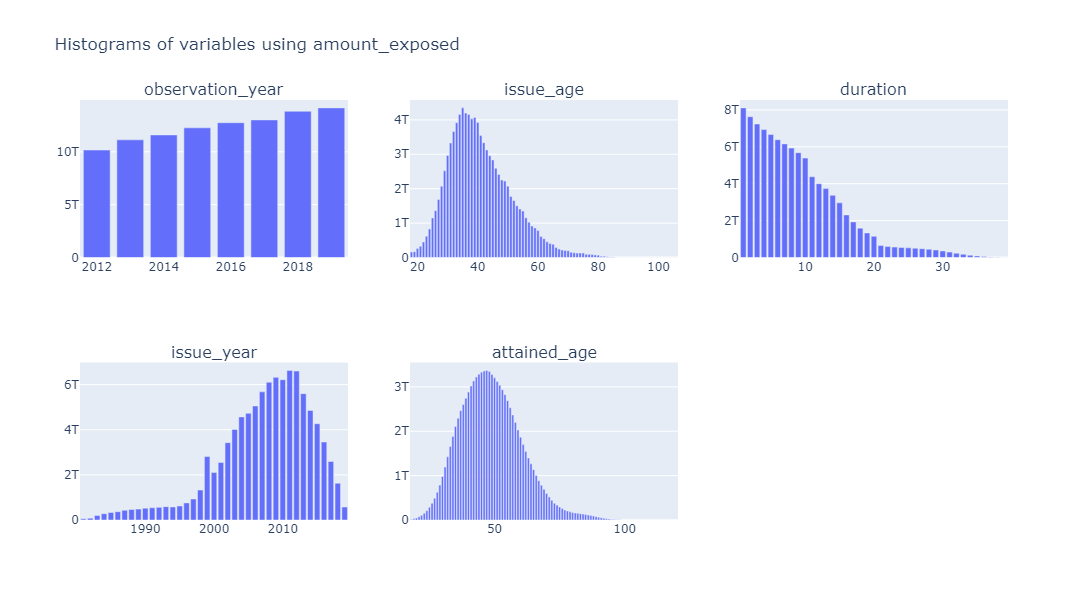

In [26]:
charters.histogram(
    df,
    cols=3,
    features=[
        "observation_year",
        "issue_age",
        "duration",
        "issue_year",
        "attained_age",
    ],
    sum_var="amount_exposed",
).show()

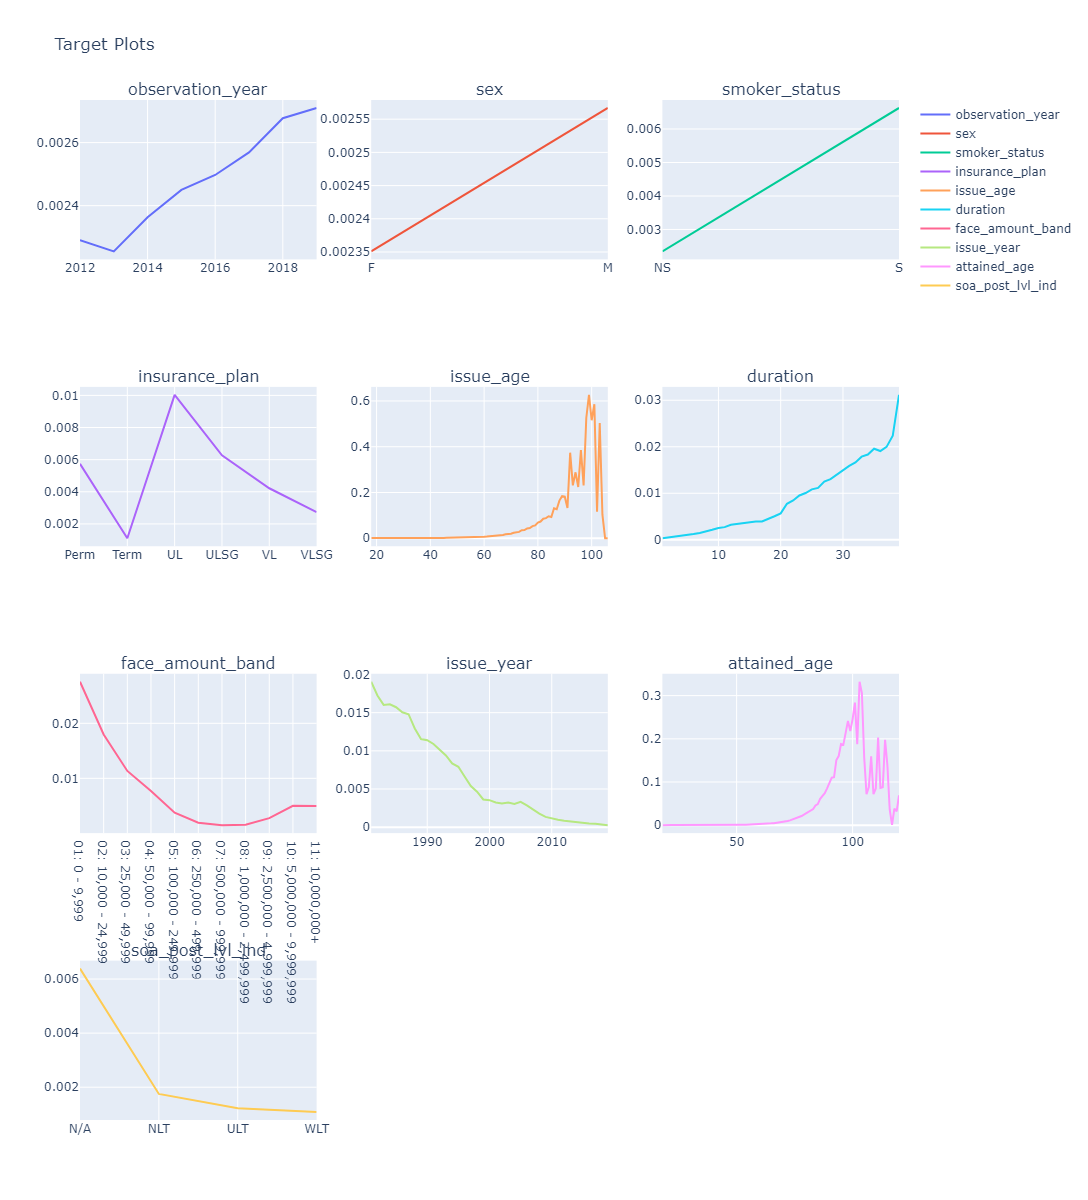

In [27]:
charters.target(
    df,
    cols=3,
    features=[
        "observation_year",
        "sex",
        "smoker_status",
        "insurance_plan",
        "issue_age",
        "duration",
        "face_amount_band",
        "issue_year",
        "attained_age",
        "soa_post_lvl_ind",
        # "slct_ult_ind",
        # "preferred_indicator",
        # "number_of_pfd_classes",
        # "preferred_class",
    ],
).show()

### Categorical

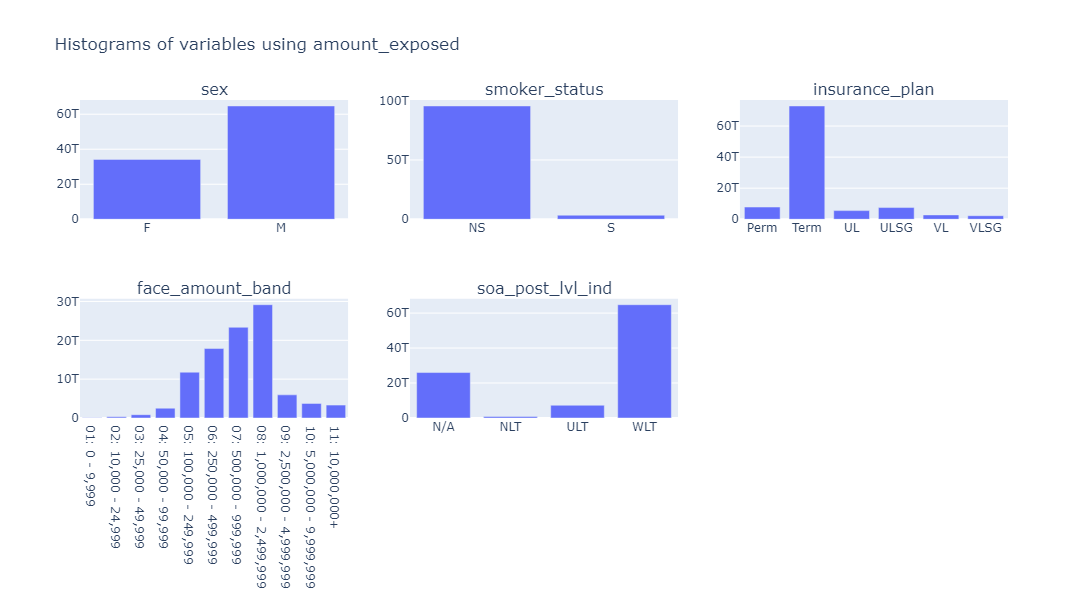

In [28]:
charters.histogram(df, cols=3, sum_var="amount_exposed").show()

### Other

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5673619 entries, 0 to 5673618
Data columns (total 17 columns):
 #   Column              Dtype   
---  ------              -----   
 0   observation_year    int32   
 1   sex                 category
 2   smoker_status       category
 3   insurance_plan      category
 4   issue_age           int32   
 5   duration            int32   
 6   face_amount_band    category
 7   issue_year          int32   
 8   attained_age        int32   
 9   soa_post_lvl_ind    category
 10  amount_exposed      float64 
 11  policies_exposed    float64 
 12  death_claim_amount  int32   
 13  death_count         int32   
 14  expdth_amt_vbt2015  float64 
 15  qx_raw              float64 
 16  qx_vbt              float64 
dtypes: category(5), float64(5), int32(7)
memory usage: 395.0 MB


In [30]:
memory_usage_per_column = df.memory_usage(deep=True)
most_memory_column = memory_usage_per_column.idxmax()
print(f"Memory usage per column:\n{memory_usage_per_column}")
print(f"Column consuming the most memory: {most_memory_column}")

Memory usage per column:
Index                      128
observation_year      22694476
sex                    5673746
smoker_status          5673844
insurance_plan         5674153
issue_age             22694476
duration              22694476
face_amount_band       5674769
issue_year            22694476
attained_age          22694476
soa_post_lvl_ind       5674031
amount_exposed        45388952
policies_exposed      45388952
death_claim_amount    22694476
death_count           22694476
expdth_amt_vbt2015    45388952
qx_raw                45388952
qx_vbt                45388952
dtype: int64
Column consuming the most memory: amount_exposed


In [31]:
nan_counts = df.isna().sum()
nan_counts

observation_year      0
sex                   0
smoker_status         0
insurance_plan        0
issue_age             0
duration              0
face_amount_band      0
issue_year            0
attained_age          0
soa_post_lvl_ind      0
amount_exposed        0
policies_exposed      0
death_claim_amount    0
death_count           0
expdth_amt_vbt2015    0
qx_raw                0
qx_vbt                0
dtype: int64

<Axes: >

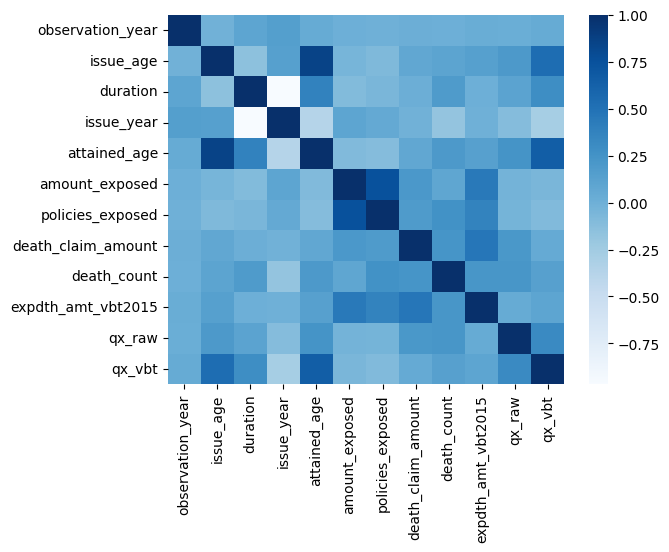

In [32]:
corr = df.select_dtypes(include=["float64", "int64", "int32"]).corr()
sns.heatmap(corr, cmap="Blues")

## Mortality by Age

Mortality qx seems to be increasing by observation year, however as we shall see this is just a function of age

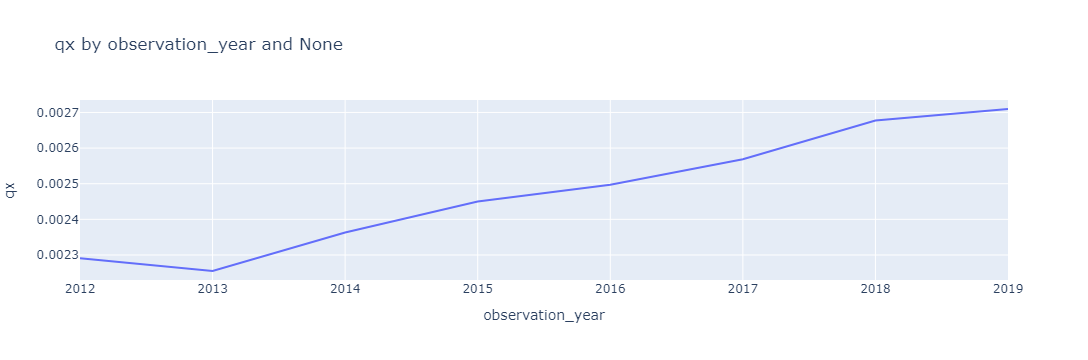

In [33]:
charters.chart(
    data=df,
    x_axis="observation_year",
    y_axis="qx",
    color=None,
    type="line",
    actual="death_claim_amount",
    expected="expdth_amt_vbt2015",
    exposure="amount_exposed",
)

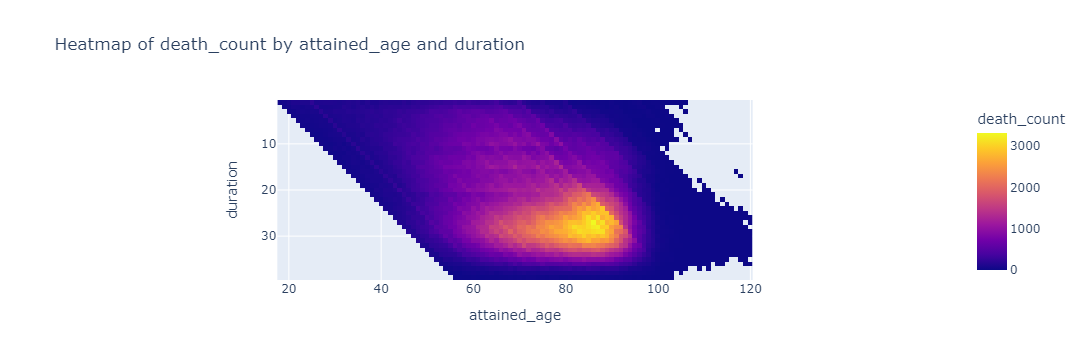

In [34]:
charters.chart(
    data=df,
    x_axis="attained_age",
    y_axis="duration",
    color="death_count",
    type="heatmap",
    actual="death_claim_amount",
    expected="expdth_amt_vbt2015",
    exposure="amount_exposed",
)

# Preparing Data

In [35]:
model_data = df[(df["attained_age"] >= 50) & (df["attained_age"] <= 95)].copy()
# model_data = df
model_data = model_data.reset_index(drop=True)

In [36]:
model_data['aa_square']=model_data['attained_age']**2

In [37]:
model_features = [
    "observation_year",
    "sex",
    "smoker_status",
    "insurance_plan",
    # "attained_age",
    "duration",
    "face_amount_band",
    "issue_year",
    "aa_square",
    # "slct_ult_ind",
    # "preferred_indicator",
    # "number_of_pfd_classes",
    # "preferred_class",
]
model_target = "qx_raw"
model_weight = "amount_exposed"

In [38]:
numeric_features = model_data.select_dtypes(include=[np.number]).columns.to_list()
ordinal_features = [
    "sex",
    "smoker_status",
    "slct_ult_ind",
    "preferred_indicator",
    "number_of_pfd_classes",
    "preferred_class",
]
nominal_features = ["insurance_plan", "face_amount_band"]

In [39]:
preprocess_dict = preprocessors.preprocess_data(
    model_data[model_features + [model_target] + [model_weight]],
    model_target,
    numeric_features,
    ordinal_features,
    nominal_features,
    model_weight=model_weight,
    standardize=True,
)

2024-02-09 21:31:16,982 xact.models.preprocessors INFO: numeric - passthrough: ['observation_year', 'duration', 'issue_year', 'aa_square']
2024-02-09 21:31:17,330 xact.models.preprocessors INFO: ordinal - ordinal encoded: ['sex', 'smoker_status']
2024-02-09 21:31:20,840 xact.models.preprocessors INFO: nominal - weighted average encoded: ['insurance_plan', 'face_amount_band']
2024-02-09 21:31:23,483 xact.models.preprocessors INFO: standardizing the data


In [40]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

In [41]:
X.dtypes

observation_year    float64
duration            float64
issue_year          float64
aa_square           float64
sex                 float64
smoker_status       float64
insurance_plan      float64
face_amount_band    float64
dtype: object

# Forecasting Models

## GLM

In [42]:
GLM = forecasters.GLM(X, y, weights)
GLM.fit_model()

2024-02-09 21:31:25,751 xact.models.forecasters INFO: initialzed GLM and add constant to X
2024-02-09 21:31:26,435 xact.models.forecasters INFO: fitting GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x00000248FAB110A0> family...


In [43]:
print(GLM.model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 qx_raw   No. Observations:              3864213
Model:                            GLM   Df Residuals:        44120815633041.02
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.5570e+11
Date:                Fri, 09 Feb 2024   Deviance:                   5.9869e+11
Time:                        21:32:03   Pearson chi2:                 2.50e+12
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.6102   3.66e-06  

In [44]:
predictions = GLM.model.predict(GLM.X)
print(f"NA values: {predictions.isna().sum()}")

NA values: 0


In [45]:
model_data["qx_pred"] = predictions
print(
    f"qx mean: {model_data['qx_raw'].mean()},\n"
    f"pred mean: {model_data['qx_pred'].mean()}"
)

qx mean: 0.022660007487856664,
pred mean: 0.02833120129206793


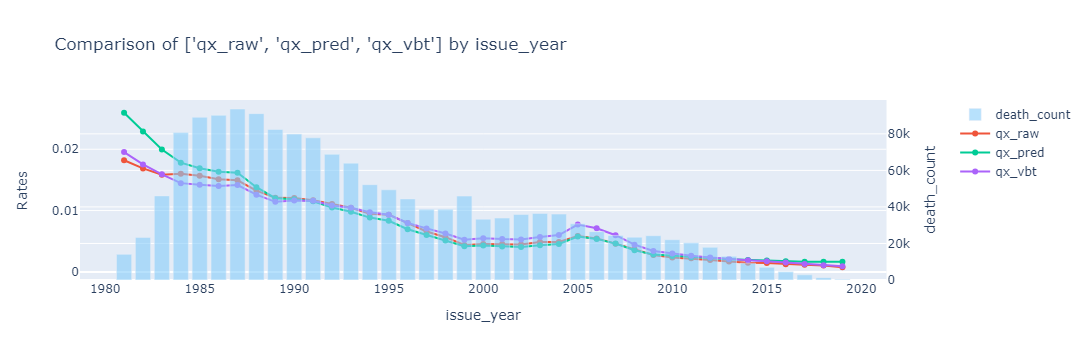

In [46]:
charters.compare_rates(
    model_data,
    variable="issue_year",
    rates=["qx_raw", "qx_pred", "qx_vbt"],
    weights="amount_exposed",
    secondary="death_count",
)

In [47]:
GLM.get_odds()

2024-02-09 21:32:06,091 xact.models.forecasters INFO: generating odds ratio from model


const              0.01
observation_year   1.10
duration           0.78
issue_year         0.61
aa_square          3.98
sex                1.17
smoker_status      1.52
insurance_plan     1.01
face_amount_band   1.13
dtype: float64

2024-02-09 21:32:06,124 xact.models.forecasters INFO: generating odds ratio from model


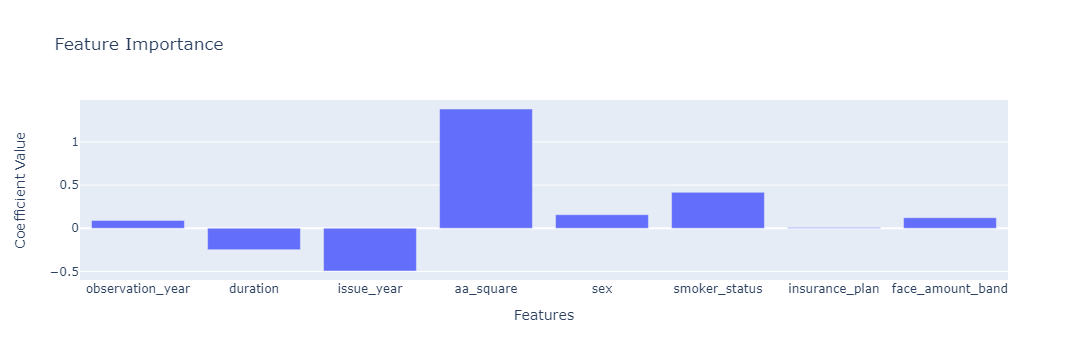

In [48]:
GLM.get_odds(display=True)

2024-02-09 21:32:06,255 xact.utils.charters INFO: Creating partial dependence plot for issue_year


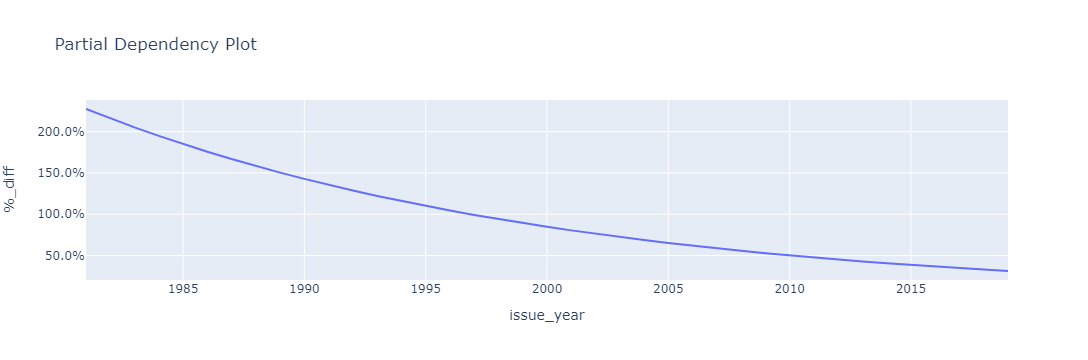

In [49]:
charters.pdp(GLM.model, GLM.X, "issue_year", mapping)

In [50]:
metrics.get_metrics(
    y_true=model_data["qx_raw"]*model_data["amount_exposed"],
    y_pred=model_data["qx_pred"]*model_data["amount_exposed"],
    metrics=["smape", "r2_score", "mean_squared_error"],
    # sample_weight=model_data["amount_exposed"],
)

{'smape': 1.7782982433041483,
 'r2_score': 0.22432197675529697,
 'mean_squared_error': 144013671394.71277}

In [51]:
metrics.get_metrics(
    y_true=model_data["qx_raw"]*model_data["amount_exposed"],
    y_pred=model_data["qx_vbt"]*model_data["amount_exposed"],
    metrics=["smape", "r2_score", "mean_squared_error"],
    # sample_weight=model_data["amount_exposed"],
)

{'smape': 1.7784945290433896,
 'r2_score': 0.20713288431521992,
 'mean_squared_error': 147205026874.7657}

## Decision Tree

In [120]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()
clf.fit(X, y, sample_weight=weights)

DecisionTreeRegressor()

In [121]:
# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns
feature_importances = zip(feature_names, importances)
for name, importance in sorted(feature_importances, key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance:.4f}")

attained_age: 0.2639
duration: 0.1569
issue_year: 0.1561
face_amount_band: 0.1391
observation_year: 0.1343
insurance_plan: 0.1197
sex: 0.0196
smoker_status: 0.0104


In [ ]:
sklearn.tree.plot_tree(clf)

## Linear Regression

scikit-lean doesn't support logistic regression for continuous variables out of the box.

the variables would need to be transformed and then use a linear regressor on them

In [118]:
from sklearn import linear_model

clf = linear_model.LinearRegression()
clf.fit(X, y, sample_weight=weights)
predictions = clf.predict(X)

In [119]:
coefficients = clf.coef_
feature_names = X.columns
feature_importances = zip(feature_names, coefficients)
for name, coef in sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True):
    print(f"{name}: {coef:.4f}")

attained_age: 0.0055
smoker_status: 0.0015
duration: 0.0011
insurance_plan: 0.0010
issue_year: 0.0005
sex: -0.0002
observation_year: -0.0001
face_amount_band: 0.0001


## Lee Carter

The Lee-Carter model is formulated as follows:

$$\log(m_{x,t}) = a_{x} + b_{x}k_{t} + \epsilon_{x,t}$$

source: https://en.wikipedia.org/wiki/Lee%E2%80%93Carter_model

Where:
- $m_{x,t}$ is the _matrix mortality rate_ at age $x$ in year $t$
- $a_{x}$ describes the general _shape_ of mortality at age $x$ (mean of the time-averaged logs of the central mortality rate at age $x$). This is known as the _age effect_ on mortality.
- $b_{x}$ measures the change in the rates at age $x$ due to a change in the underlying time trend, $k_{t}$.
- $k_{t}$ reflects the effect of the time trend, $t$, on mortality.
- $\epsilon_{x,t}$ are i.i.d. normal random variables with zero means and constant variance, $\sigma^{2}$.

The following constraints are imposed:
$$\sum_{x}b_{x} = 1$$
$$\sum_{t}k_{t} = 0$$

The derivation below is an alternative to the Singular Value Decomposition (SVD) approach found in literature. This approach seeks to minimise the sum of squares for error to determine estimates for the parameters.

We take the following approach to find estimates for these parameters:

1. We first find $\hat{a}_{x}$ by calculating $\frac{1}{n}\sum_{t=1}^{n}\log(\hat{m}_{x,t})$.

2. We can estimate the values of $k_{t}$ by summing across all ages $x$ and re-arranging the following:

$$\sum_{x}\log(m_{x,t}) = \sum_{x}a_{x} + k_{t}\sum_{x}b_{x} + \sum_{x}\epsilon_{x,t}$$

Which gives (noting $\sum_{x}b_{x} = 1$, by our constraint):

$$\hat{k}_t = \sum_{x}\log(\hat{m}_{x,t})-\sum_{x}\hat{a}_{x} = \sum_{x}(\log(\hat{m}_{x,t}) - \frac{1}{n}\sum_{t=1}^{n}\log(\hat{m}_{x,t}))$$


3. To estimate values for $\hat{b}_{t}$, we use the sum of squared error terms and minimise with respect to $b_{x}$. This gives us:

$$\sum_{t}\sum_{x}\epsilon^{2}_{x,t} = \sum_{t}\sum_{x}(\log(m_{x,t}) - a_{x} - b_{x}k_{t})^2$$

Minimising with respect to $b_{x}$ gives us:

$$\hat{b}_{x} = \frac{\sum_{t}\hat{k}_{t}(\log(\hat{m}_{x,t}) - \hat{a}_{x})}{\sum_{t}\hat{k}^{2}_{t}}$$

4. We now have everything needed to calculate our mortality estimates using:

$$\hat{m}_{x,t}^{LC} = \exp(\hat{a}_{x}+\hat{b}_{x}\hat{k}_{t})$$

In [398]:
model_data = df[(df["attained_age"] >= 55) & (df["attained_age"] <= 95)]

In [504]:
importlib.reload(forecasters)

<module 'xact.models.forecasters' from 'C:\\Users\\johnk\\Desktop\\github\\xact\\xact\\models\\forecasters.py'>

In [505]:
lc = forecasters.LeeCarter()

2024-02-06 23:11:56,781 xact.models.forecasters INFO: initialized LeeCarter


In [506]:
crude_df = lc.structure_df(model_data)

2024-02-06 23:11:57,047 xact.models.forecasters INFO: grouping data by age and year
2024-02-06 23:11:57,472 xact.models.forecasters INFO: calculating qx_raw rates
2024-02-06 23:11:57,487 xact.models.forecasters INFO: there were 0 rates over 1 that were capped.
2024-02-06 23:11:57,494 xact.models.forecasters INFO: crude_df shape: (328, 5)


In [507]:
lc_df = lc.get_forecast(crude_df)

2024-02-06 23:11:58,285 xact.models.forecasters INFO: creating Lee Carter model with qx_raw rates...
2024-02-06 23:11:58,295 xact.models.forecasters INFO: age range: 55, 95
2024-02-06 23:11:58,298 xact.models.forecasters INFO: year range: 2012, 2019
2024-02-06 23:11:58,306 xact.models.forecasters INFO: calculating qx_lc = exp(a_x + b_x * k_t)
2024-02-06 23:11:58,306 xact.models.forecasters INFO: adding qx_lc to crude_df


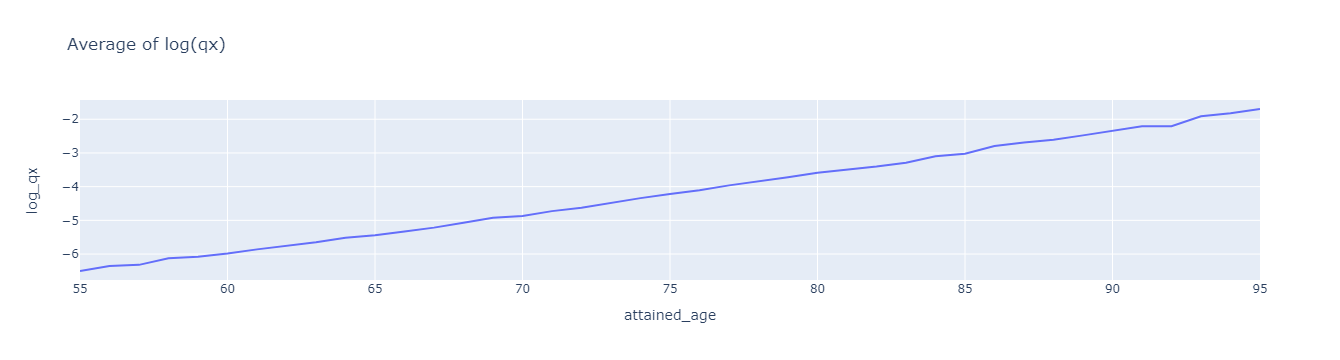

In [508]:
charters.chart(
    data=lc.a_x.reset_index(),
    x_axis="attained_age",
    y_axis=0,
    color=None,
    type="line",
    title="Average of log(qx)",
    labels={"attained_age": "attained_age", "0": "log_qx"},
)

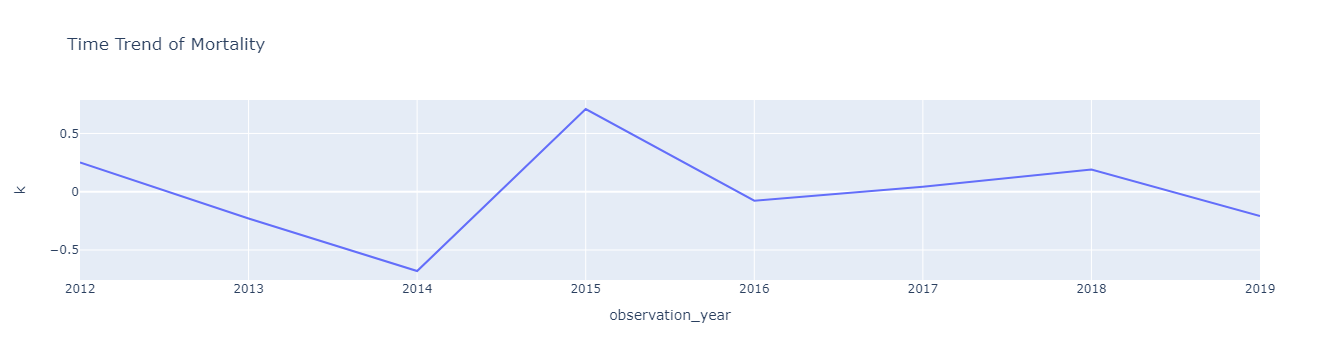

In [509]:
charters.chart(
    data=lc.k_t.reset_index(),
    x_axis="observation_year",
    y_axis=0,
    color=None,
    type="line",
    title="Time Trend of Mortality",
    labels={"observation_year": "observation_year", "0": "k"},
)

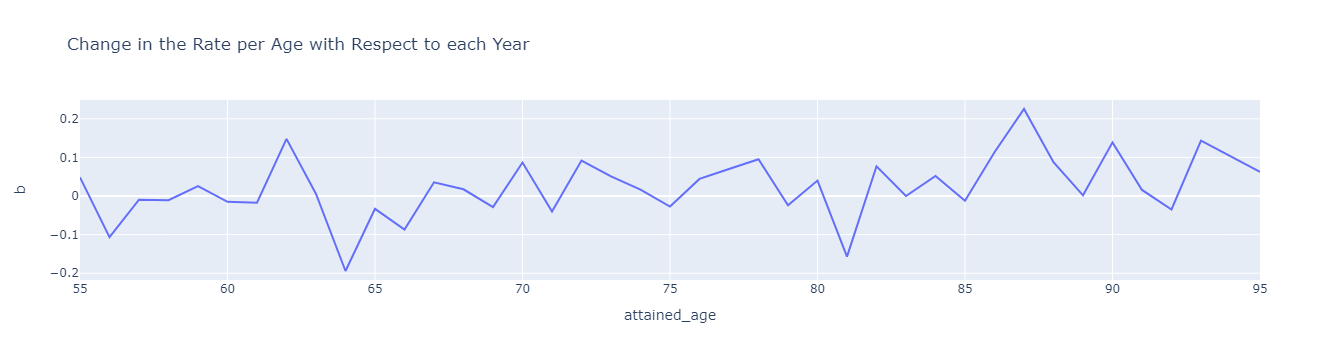

In [510]:
charters.chart(
    data=lc.b_x.reset_index(),
    x_axis="attained_age",
    y_axis=0,
    color=None,
    type="line",
    title="Change in the Rate per Age with Respect to each Year",
    labels={"attained_age": "attained_age", "0": "b"},
)

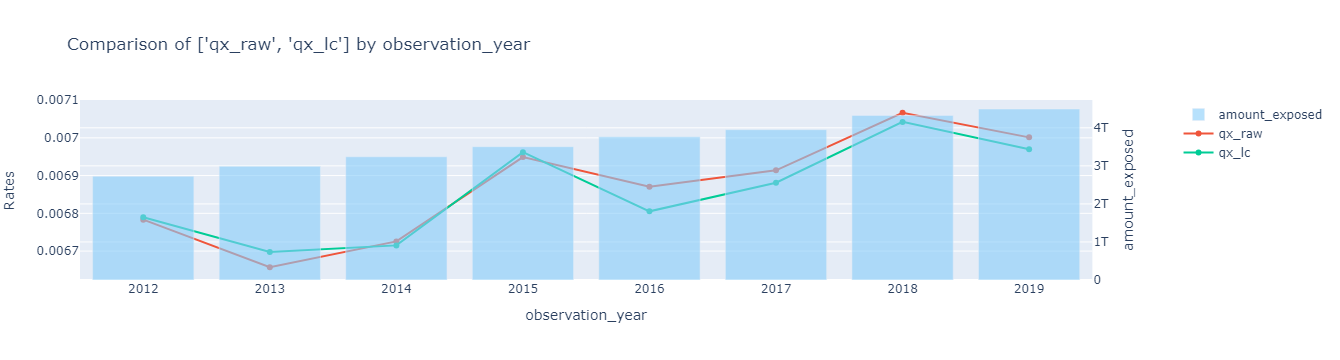

In [511]:
charters.compare_rates(
    lc_df,
    variable="observation_year",
    rates=["qx_raw", "qx_lc"],
    weights="amount_exposed",
    secondary="amount_exposed",
)

In [512]:
metrics.get_metrics(
    y_true=lc_df["qx_raw"],
    y_pred=lc_df["qx_lc"],
    metrics=["smape", "r2_score"],
    sample_weight=lc_df["amount_exposed"],
)

{'smape': 0.06560874671135986, 'r2_score': 0.9867181520020009}

## Cairns-Blake-Dowd Model

The Cairns-Blake-Dowd (CBD) model is a stochastic mortality model, and a variant of the Lee-Carter mortality model. It is designed with longevity risk in mind, particularly attempting to understand and forecast mortality at older ages.

The model is in the following form:

$$\text{logit}(_{t}q_{x}) = \kappa_{t}^{(1)} + (x - \bar{x})\kappa_{t}^{(2)}$$

- $\text{logit}(\alpha) = \log\big(\frac{\alpha}{1-\alpha}\big)$
- $\kappa_{t}^{(1)}$  is the _level_ factor, varying with respect to year $t \in (t_{1}, t_{2}, \dots, t_{q})$
- $\kappa_{t}^{(2)}$  is the _slope_ factor, varying with respect to year $t \in (t_{1}, t_{2}, \dots, t_{q})$
- $x$ is the age group, $x \in (x_{1}, x_{2}, \dots, x_{p})$
- $\bar{x}$ is the average of the age group
- $_{t}q_{x}$ is the probability an individual aged $x$ last birthday dies before age $x+t$

We will be using method of least-squares to get estimates $\hat{\kappa}^{(1)}$ and $\hat{\kappa}^{(2)}$.

Further information:
- https://www.actuaries.org/AFIR/Colloquia/Rome2/Cairns_Blake_Dowd.pdf - further discussion on the merits of the CBD model (such as age-period cohort effects and further extensions to the CBD model).
- Safitri Y. R., Mardiyati S, and Malik M. 2019. The Cairns-Blake-Dowd model to forecast Indonesian mortality rates. AIP Conference Proceedings 2168, 020041. Published Online: 04 November 2019.

Defining $\text{logit}(_{t}q_{x})$

Depending on if the mortality rate uses the central mortality rate (mx) or the initial mortality rate (qx) there will be a different conversion to align the rates.

**UDD assumption**

$$m_{x} \approx \frac{2q_{x}}{2-q_{x}}$$

$$q_{x} \approx \frac{2m_{x}}{2+m_{x}}$$

**Constant Force assumption**

$$m_{x} \approx -\log{(1-q_{x})}$$

$$q_{x} \approx 1-\exp(-m_{x})$$

The following logic can be used to convert $\text{logit}(\alpha)$ to ${q}_{x}$

$$\text{logit}(\alpha) = \log\big(\frac{\alpha}{1-\alpha}\big) = k$$

$$\frac{\alpha}{1-\alpha} = \text{e}^{k}$$

$$\alpha = \text{e}^{k}(1-\alpha)$$

$$\alpha(1+\text{e}^{k}) = \text{e}^{k}$$

$$\alpha = \frac{\text{e}^{k}}{1+\text{e}^{k}}$$

In [394]:
importlib.reload(forecasters)

<module 'xact.models.forecasters' from 'C:\\Users\\johnk\\Desktop\\github\\xact\\xact\\models\\forecasters.py'>

In [353]:
model_data = df[(df["attained_age"] >= 55) & (df["attained_age"] <= 95)]

In [387]:
cbd = forecasters.CBD()

2024-02-06 22:23:13,919 xact.models.forecasters INFO: initialized


In [388]:
crude_df = cbd.structure_df(model_data)

2024-02-06 22:23:14,420 xact.models.forecasters INFO: grouping data by age and year
2024-02-06 22:23:14,943 xact.models.forecasters INFO: calculating qx_raw rates
2024-02-06 22:23:14,952 xact.models.forecasters INFO: there were 0 rates over 1 that were capped.
2024-02-06 22:23:14,952 xact.models.forecasters INFO: crude_df shape: (328, 5)


In [389]:
cbd_df = cbd.get_forecast(crude_df)

2024-02-06 22:23:14,975 xact.models.forecasters INFO: creating CBD model with qx_raw rates...
2024-02-06 22:23:14,983 xact.models.forecasters INFO: age range: 55, 95
2024-02-06 22:23:14,983 xact.models.forecasters INFO: average age: 75.0
2024-02-06 22:23:14,983 xact.models.forecasters INFO: year range: 2012, 2019
2024-02-06 22:23:14,996 xact.models.forecasters INFO: adding qx_cbd to crude_df


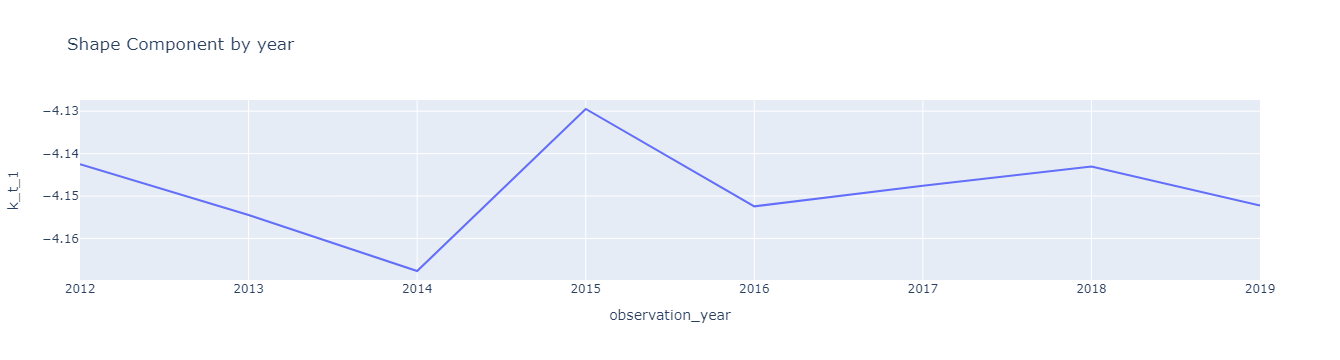

In [390]:
# shape shows the impact of time on mortality
charters.chart(
    data=cbd.k_t_1.reset_index(),
    x_axis=cbd.year_col,
    y_axis=0,
    color=None,
    type="line",
    title="Shape Component by year",
    labels={"0": "k_t_1"},
)

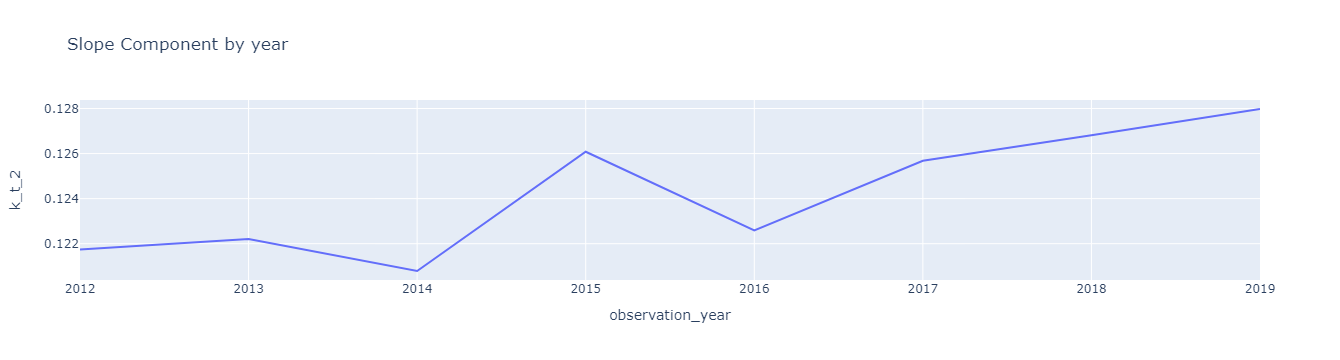

In [391]:
# slope shows if the impact of time is different by year
charters.chart(
    data=cbd.k_t_2.reset_index(),
    x_axis=cbd.year_col,
    y_axis=0,
    color=None,
    type="line",
    title="Slope Component by year",
    labels={"0": "k_t_2"},
)

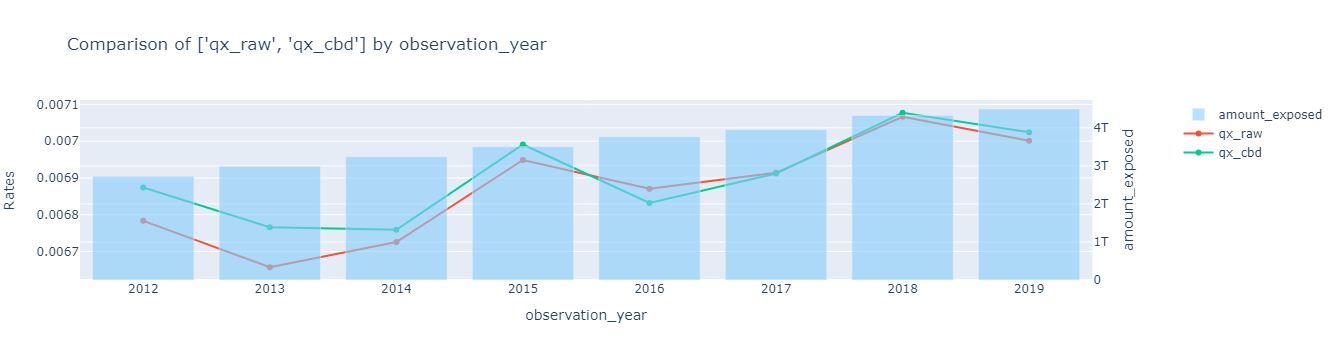

In [392]:
charters.compare_rates(
    cbd_df,
    variable="observation_year",
    rates=["qx_raw", "qx_cbd"],
    weights="amount_exposed",
    secondary="amount_exposed",
)

In [393]:
metrics.get_metrics(
    y_true=cbd_df["qx_raw"],
    y_pred=cbd_df["qx_cbd"],
    metrics=["smape", "r2_score"],
    sample_weight=cbd_df["amount_exposed"],
)

{'smape': 0.08900514261536505, 'r2_score': 0.9808762486531324}

# Visualization

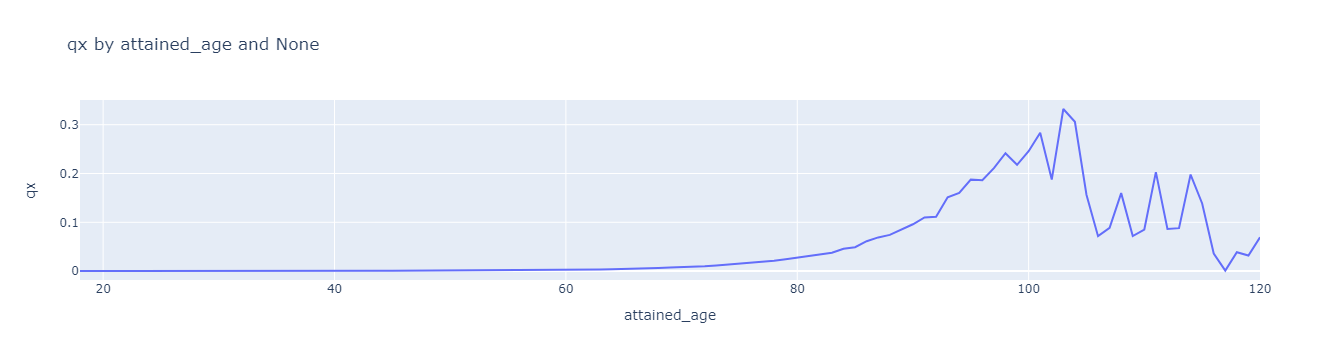

In [36]:
charters.chart(
    data=df,
    x_axis="attained_age",
    y_axis="qx",
    color=None,
    type="line",
    actual="death_claim_amount",
    expected="expdth_amt_vbt2015",
    exposure="amount_exposed",
)

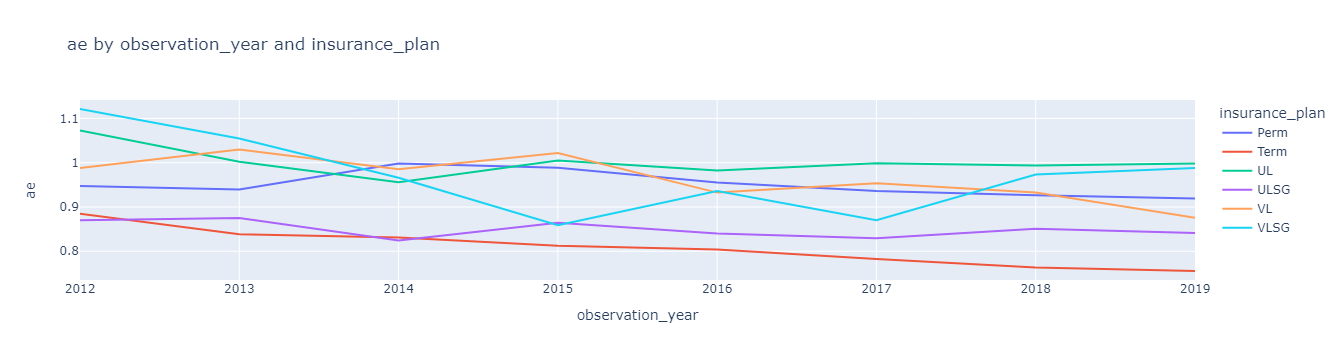

In [124]:
charters.chart(
    data=df,
    x_axis="observation_year",
    y_axis="ae",
    color="insurance_plan",
    type="line",
    actual="death_claim_amount",
    expected="expdth_amt_vbt2015",
    exposure="amount_exposed",
)

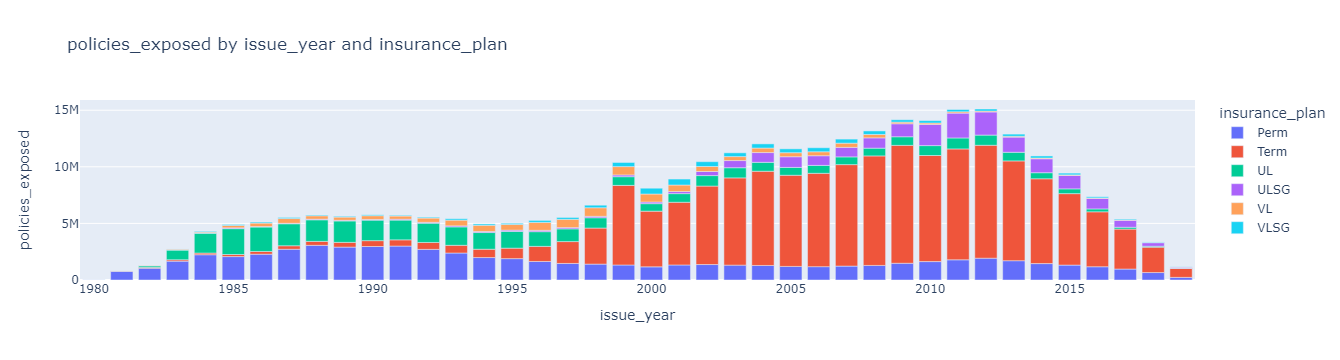

In [126]:
charters.chart(
    data=df,
    x_axis="issue_year",
    y_axis="policies_exposed",
    color="insurance_plan",
    type="bar",
    actual="death_claim_amount",
    expected="expdth_amt_vbt2015",
    exposure="amount_exposed",
)

In [77]:
# charters.scatter(df=df, target="qx_raw", numeric=True, sample_nbr=1000).show()

# Reload

In [ ]:
importlib.reload(helpers)

In [363]:
importlib.reload(forecasters)

<module 'xact.models.forecasters' from 'C:\\Users\\johnk\\Desktop\\github\\xact\\xact\\models\\forecasters.py'>

In [ ]:
importlib.reload(preprocessors)

In [104]:
importlib.reload(charters)

<module 'xact.utils.charters' from 'C:\\Users\\johnk\\Desktop\\github\\xact\\xact\\utils\\charters.py'>

In [59]:
importlib.reload(metrics)

<module 'xact.models.metrics' from 'C:\\Users\\johnk\\Desktop\\github\\xact\\xact\\models\\metrics.py'>

# Library

In [ ]:
from datetime import date

import plotly.express as px
import plotly.graph_objs as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

In [ ]:
spec = [(2, 7), (15, 20), (31, 40), (46, 56), (62, 72)]
df = pd.read_fwf(
    r"C:\Users\johnk\Desktop\github\actuartech\mortality\files\Mx_1x1.txt",
    skiprows=2,
    colspecs=spec,
)
df = df.drop(["Female", "Total"], axis=1)
df = df[
    ~df["Age"].isin(
        ["101", "102", "103", "104", "105", "106", "107", "108", "109", "110+"]
    )
]
df["Age"] = df["Age"].astype(int)
df["Male"] = df["Male"].astype(float)
df = df.pivot(index="Age", columns="Year", values="Male")
df.columns = df.columns.astype(str)
HMDMalesAustralianRates = df
mortality_rates = pd.DataFrame(HMDMalesAustralianRates)
mortality_rates = mortality_rates.loc[0:96, :]
mortality_rates = mortality_rates.loc[55:95, "2003":"2013"]
mortality_rates = mortality_rates.transpose()
cbd = forecasters.CBD(age_col="Age", year_col="Year")
# crude_df = cbd.structure_df(mortality_rates)
mortality_rates = mortality_rates.reset_index()
mortality_rates.rename(columns={"index": cbd.year_col}, inplace=True)
mortality_rates = mortality_rates.melt(
    id_vars=cbd.year_col, var_name=cbd.age_col, value_name="qx_raw"
)
mortality_rates.head()
mortality_rates["Year"] = mortality_rates["Year"].astype(int)
mortality_rates["Age"] = mortality_rates["Age"].astype(int)
mortality_rates["qx_raw"] = 1 - np.exp(-mortality_rates["qx_raw"])